In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int
from collections import namedtuple
from tqdm.notebook import tqdm, trange
from simglucose.patient.t1dpatient import T1DPatient

In [2]:
# better plots
sns.set_style("whitegrid")

# better progress
tqdm.pandas()

In [3]:
# read and preprocess data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

# convert to tensors
data_t = torch.from_numpy(data_t).float()
data_CHO = torch.from_numpy(data_CHO).float()
data_insulin = torch.from_numpy(data_insulin).float()
data_CGM = torch.from_numpy(data_CGM).float()

In [4]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
mean_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_range = torch.stack([torch.from_numpy(adult_params.min().to_numpy()), torch.from_numpy(adult_params.max().to_numpy())], axis=1)
def constrain_params(p):
    return ((torch.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return pd.Series({
        **mean_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    })

In [5]:
# system parameters
kp2  = torch.tensor(mean_params["kp2"]) 
k1   = torch.tensor(mean_params["k1"])
k2   = torch.tensor(mean_params["k2"])
kp1  = torch.tensor(mean_params["kp1"])
ki   = torch.tensor(mean_params["ki"])
ke1  = torch.tensor(mean_params["ke1"])
kmax = torch.tensor(mean_params["kmax"])
kmin = torch.tensor(mean_params["kmin"])
kabs = torch.tensor(mean_params["kabs"])
kp3  = torch.tensor(mean_params["kp3"])

In [6]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

def system(params, t_eval, in_t, in_CHO, in_insulin):
    patient = T1DPatient.withParams(params)

    t_trace = t_eval
    BG_trace = []
    dx_trace = []

    for t in t_trace:
        # get current action
        t_mask = np.abs(in_t - t).argmin()
        action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

        # track variables
        BG_trace.append(patient.observation.Gsub)
        dx_trace.append(patient.derivative)

        patient.step(action)

    BG_trace = torch.tensor(np.array(BG_trace), dtype=torch.float32)
    dx_trace = torch.tensor(np.array(dx_trace), dtype=torch.float32)

    return t_trace, BG_trace, dx_trace

def ode(t):
    params = construct_params(torch.hstack([kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]))
    out = system(params, t, data_t, data_CHO, data_insulin)
    return out[2]

In [7]:
dxs = ode(data_t)

In [8]:
# initial conditions
f_0 = torch.from_numpy(mean_params.iloc[2:15].to_numpy())

In [9]:
# timespan
tspan = (data_t[0], data_t[-1])

In [10]:
# enfore ICs
def output_transform(t, u, u_0):
    return u * torch.tanh(t) + u_0

In [11]:
# generate features
features = torch.vstack((data_t, data_CHO, data_insulin)).T

In [12]:
# ODE loss
def ode_loss(model, ode, f_0, features):
    # generate features
    # t = data_t.reshape(-1, 1) # torch.FloatTensor(100, 1).uniform_(*tspan)
    # t.requires_grad_(True)
    # features = torch.vstack((data_t, data_CHO, data_insulin)).T
    features.requires_grad_(True)

    # get preds
    NN_t = model(features)
    NN_t = output_transform(features[:, 0:1], NN_t, f_0)

    dNN_dt = torch.hstack([
        autograd.grad(
            NN_t[:, i:i+1],
            features[:, 0:1],
            grad_outputs=torch.ones_like(features[:, 0:1]),
            create_graph=True,
            retain_graph=True,
        )[0]
        for i in range(13)
    ])

    df_dt = ode(data_t)

    loss = F.mse_loss(dNN_dt, df_dt)

    return loss

In [13]:
# train model for given number of epochs
def train(model, opt, epochs, informed=False, logfreq=100):
    # train model
    loss_history = []
    for epoch in (pbar := trange(epochs)):
        opt.zero_grad()

        # data loss
        preds = model(features)
        loss = F.mse_loss(preds[:, 12:13], data_CGM.reshape(-1, 1))

        # ode loss
        if informed:
            loss += ode_loss(model, ode, f_0)

        loss.backward()
        opt.step()

        if epochs % logfreq == 0 or epoch == epochs - 1:
            pbar.set_postfix(loss=f"{loss.item():.2e}")
            loss_history.append(loss.item())

    return loss_history

In [14]:
# network
model = nn.Sequential(
    nn.Linear(3, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 13),
)

In [15]:
# optimizer
opt = optim.Adam(model.parameters())

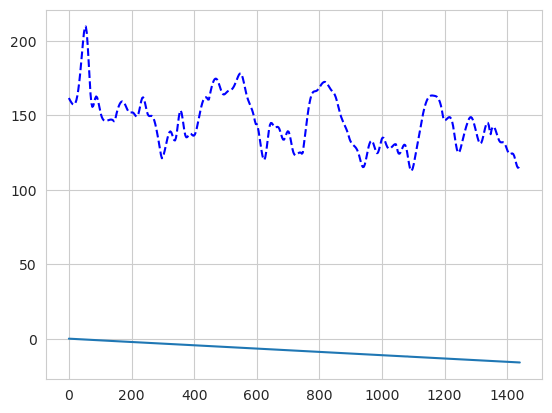

In [16]:
preds = model(features)[:, 12:13].detach().numpy()

plt.plot(data_t, data_CGM, "b--")
plt.plot(data_t, preds)
plt.show()

In [17]:
# train network
epochs = 100
loss_history = train(model, opt, epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

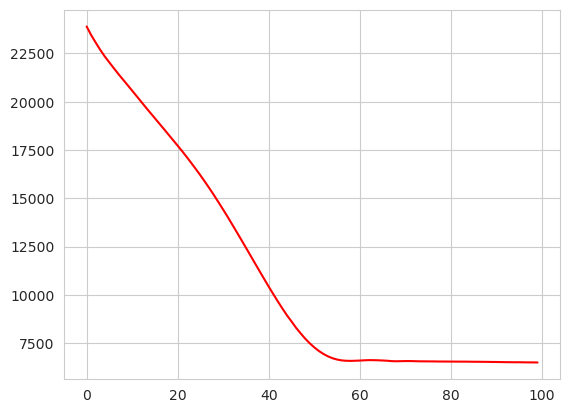

In [18]:
# plot loss history
plt.plot(loss_history, "r")
plt.show()

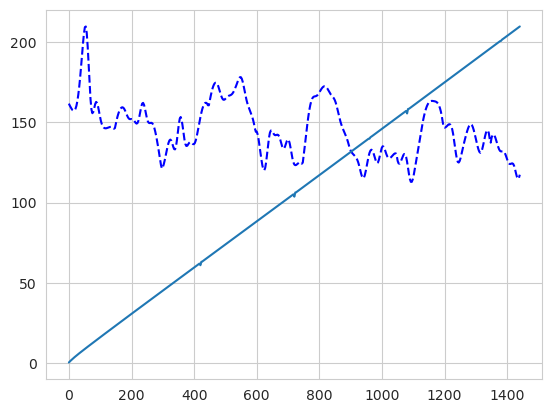

In [19]:
preds = model(features)[:, 12:13].detach().numpy()

plt.plot(data_t, data_CGM, "b--")
plt.plot(data_t, preds)
plt.show()

In [ ]:
def ode(t, x, inputs, params):
    # destructure inputs
    in_time, in_CHO, in_insulin = inputs

    # instantiate derivatives
    dxdt = np.zeros(13)

    # get current action
    t_mask = np.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -params.kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar))
            - np.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = params.kmax

    # stomach liquid
    dxdt[1] = params.kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - params.kabs * x[2]

    # Rate of appearance
    Rat = params.f * params.kabs * x[2] / params.BW
    # Glucose Production
    EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = params.ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - params.k1 * x[3] + params.k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -params.ki * (x[7] - It)

    dxdt[8] = -params.ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt